# Problem statement 

The goal of this project is to predict the effectiveness of a drug in cancer cell lines using machine learning. Given features such as cell line characteristics, drug properties, and genomic data, the model will predict drug response, quantified by LN_IC50 (log-transformed half-maximal inhibitory concentration), which indicates drug sensitivity.

In [6]:
df.shape

(242035, 19)

# Data preprocessing

In [7]:
#Handle missing values.
#Encode categorical features.
#Normalize numerical features.
#Merge datasets if necessary

HANDLING THE MISSING VALUES

In [8]:
df.isnull().sum()

COSMIC_ID                                      0
CELL_LINE_NAME                                 0
TCGA_DESC                                   1067
DRUG_ID                                        0
DRUG_NAME                                      0
LN_IC50                                        0
AUC                                            0
Z_SCORE                                        0
GDSC Tissue descriptor 1                    9366
GDSC Tissue descriptor 2                    9366
Cancer Type (matching TCGA label)          51446
Microsatellite instability Status (MSI)    12353
Screen Medium                               9366
Growth Properties                           9366
CNA                                         9366
Gene Expression                             9366
Methylation                                 9366
TARGET                                     27155
TARGET_PATHWAY                                 0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242035 entries, 0 to 242034
Data columns (total 19 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   COSMIC_ID                                242035 non-null  int64  
 1   CELL_LINE_NAME                           242035 non-null  object 
 2   TCGA_DESC                                240968 non-null  object 
 3   DRUG_ID                                  242035 non-null  int64  
 4   DRUG_NAME                                242035 non-null  object 
 5   LN_IC50                                  242035 non-null  float64
 6   AUC                                      242035 non-null  float64
 7   Z_SCORE                                  242035 non-null  float64
 8   GDSC Tissue descriptor 1                 232669 non-null  object 
 9   GDSC Tissue descriptor 2                 232669 non-null  object 
 10  Cancer Type (matching TCGA label

In [10]:
# Drop columns with too many missing values (optional)
df_cleaned = df.dropna(subset=["Cancer Type (matching TCGA label)", "TARGET"])

# Fill missing values for categorical columns
categorical_cols = ["GDSC Tissue descriptor 1", "GDSC Tissue descriptor 2"]
for col in categorical_cols:
    df_cleaned[col].fillna("Unknown", inplace=True)

# Convert categorical variables to numerical using label encoding
from sklearn.preprocessing import LabelEncoder

encoder_cols = ["Cancer Type (matching TCGA label)", "TARGET", "TARGET_PATHWAY"]
label_encoders = {}

for col in encoder_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le  # Store the encoder for inverse transformation if needed

# Verify cleaned data
df_cleaned.info()
df_cleaned.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 169277 entries, 0 to 242033
Data columns (total 19 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   COSMIC_ID                                169277 non-null  int64  
 1   CELL_LINE_NAME                           169277 non-null  object 
 2   TCGA_DESC                                168917 non-null  object 
 3   DRUG_ID                                  169277 non-null  int64  
 4   DRUG_NAME                                169277 non-null  object 
 5   LN_IC50                                  169277 non-null  float64
 6   AUC                                      169277 non-null  float64
 7   Z_SCORE                                  169277 non-null  float64
 8   GDSC Tissue descriptor 1                 169277 non-null  object 
 9   GDSC Tissue descriptor 2                 169277 non-null  object 
 10  Cancer Type (matching TCGA label

,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (matching TCGA label),Microsatellite instability Status (MSI),Screen Medium,Growth Properties,CNA,Gene Expression,Methylation,TARGET,TARGET_PATHWAY
0,683667,PFSK-1,MB,1003,Camptothecin,-1.463887,0.930220,0.433123,nervous_system,medulloblastoma,18,MSS/MSI-L,R,Adherent,Y,Y,Y,165,7
5,687448,COLO-829,SKCM,1003,Camptothecin,-1.235034,0.867348,0.557727,skin,melanoma,26,MSS/MSI-L,R,Adherent,Y,Y,Y,165,7
7,687455,RT4,BLCA,1003,Camptothecin,-2.963191,0.821438,-0.383200,urogenital_system,Bladder,2,MSS/MSI-L,D/F12,Adherent,Y,Y,Y,165,7
8,687457,SW780,BLCA,1003,Camptothecin,-1.449138,0.905050,0.441154,urogenital_system,Bladder,2,MSS/MSI-L,D/F12,Adherent,Y,Y,Y,165,7
9,687459,TCCSUP,BLCA,1003,Camptothecin,-2.350633,0.843430,-0.049682,urogenital_system,Bladder,2,MSS/MSI-L,D/F12,Adherent,Y,Y,Y,165,7


# DATA ANALYSIS

(a) Correlation matrics

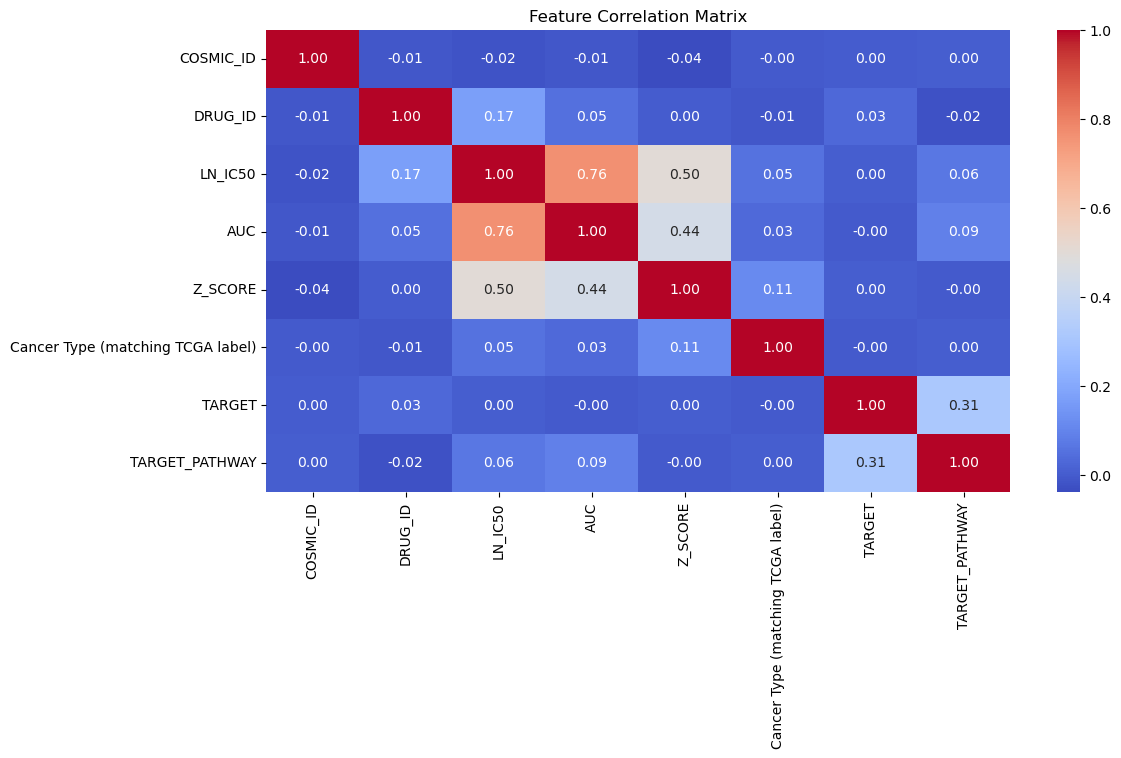

In [11]:
# Correlation heatmap for numerical features
plt.figure(figsize=(12, 6))
sns.heatmap(df_cleaned.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

(b)Drug sensitivity distribution

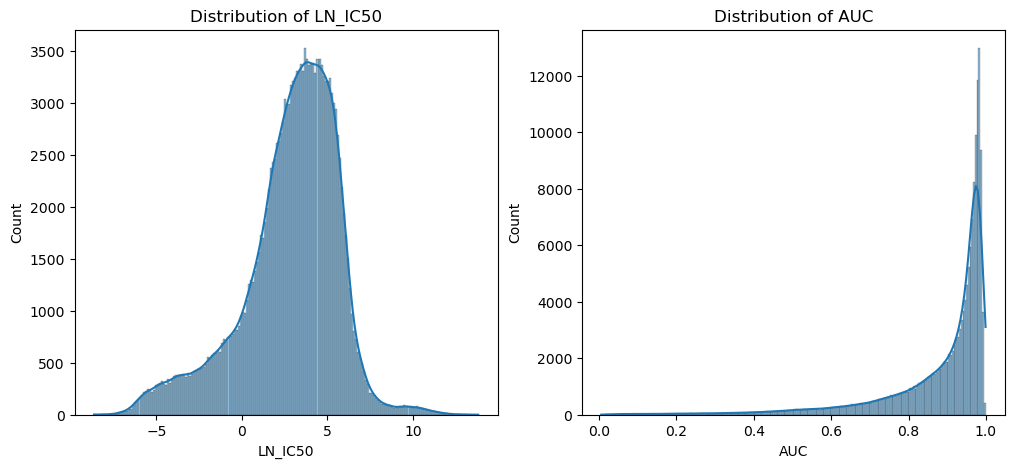

In [12]:
# Distribution of drug response (LN_IC50 & AUC)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_cleaned["LN_IC50"], kde=True, ax=axes[0])
axes[0].set_title("Distribution of LN_IC50")

sns.histplot(df_cleaned["AUC"], kde=True, ax=axes[1])
axes[1].set_title("Distribution of AUC")

plt.show()

# Meachine learning model

(a)Define Features and Target

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target variable
X = df_cleaned.drop(columns=["LN_IC50", "DRUG_NAME", "CELL_LINE_NAME"])
y = df_cleaned["LN_IC50"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


(b) Train regression model

In [15]:
# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")

ValueError: could not convert string to float: 'OV'

# converting catorgorical columns into numeric

In [16]:
# Find non-numeric columns
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
print("Categorical Columns:", categorical_cols)


Categorical Columns: Index(['CELL_LINE_NAME', 'TCGA_DESC', 'DRUG_NAME', 'GDSC Tissue descriptor 1',
       'GDSC Tissue descriptor 2', 'Microsatellite instability Status (MSI)',
       'Screen Medium', 'Growth Properties', 'CNA', 'Gene Expression',
       'Methylation'],
      dtype='object')


In [17]:
from sklearn.preprocessing import LabelEncoder

# Apply Label Encoding to all categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])  # Convert text to numbers
    label_encoders[col] = le  # Save encoders for later inverse transformation

# Verify the transformation
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169277 entries, 0 to 242033
Data columns (total 19 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   COSMIC_ID                                169277 non-null  int64  
 1   CELL_LINE_NAME                           169277 non-null  int32  
 2   TCGA_DESC                                169277 non-null  int32  
 3   DRUG_ID                                  169277 non-null  int64  
 4   DRUG_NAME                                169277 non-null  int32  
 5   LN_IC50                                  169277 non-null  float64
 6   AUC                                      169277 non-null  float64
 7   Z_SCORE                                  169277 non-null  float64
 8   GDSC Tissue descriptor 1                 169277 non-null  int32  
 9   GDSC Tissue descriptor 2                 169277 non-null  int32  
 10  Cancer Type (matching TCGA label

In [18]:
# Define Features (X) and Target (y)
X = df_cleaned.drop(columns=["LN_IC50", "DRUG_NAME", "CELL_LINE_NAME"])
y = df_cleaned["LN_IC50"]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")

Mean Squared Error: 0.0769
R-squared Score: 0.9905


#  Classification Model (If Predicting Sensitivity vs Resistance)

In [20]:
# Convert LN_IC50 to binary classification: Sensitive (0) vs Resistant (1)
df_cleaned["Drug_Response"] = df_cleaned["LN_IC50"].apply(lambda x: 1 if x < -4 else 0)

# Define new target
y_class = df_cleaned["Drug_Response"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Train a Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predictions
y_pred_class = clf.predict(X_test)

# Evaluate classification model
print("Accuracy Score:", accuracy_score(y_test, y_pred_class))
print("Classification Report:\n", classification_report(y_test, y_pred_class))

Accuracy Score: 0.9676571361058601
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     32761
           1       0.00      0.00      0.00      1095

    accuracy                           0.97     33856
   macro avg       0.48      0.50      0.49     33856
weighted avg       0.94      0.97      0.95     33856



# Final thoughts

In [21]:
#To predefined the prediction of the model to predict the drug effeciveness
# For Drug Response Prediction: Use RandomForestRegressor or XGBoost for better performance.
# For Drug Sensitivity Classification: Use Logistic Regression, SVM, or RandomForestClassifier.
# Next Steps: Try Feature Selection (PCA, SHAP values) or Hyperparameter Tuning (GridSearchCV).